#### Goal

Using Machine Learning algorithms to accurately predict the location of Uranium deposits using
surface level-data, such as magnetic and radiometric values


#### Project Description

Our main dataset for training/testing is from the United States Geological Survey and was gathered in 1976. In this survey, data was gathered by aircraft that flew over the border area of New Mexico and Texas, and recorded magnetic-field and radiometric values and locations. Contained in this dataset are latitude, longitude, altitude, and magnetic-field values. Additionally, there are geologic symbols detailing the area in the data sets. The aircrafts tracked the locations of Uranium, Thorium, and Potassium, but we will be focusing on Uranium in this project. We plan to group the different elements using Agglomerative Hierarchical Clustering. 

This section of imports displays the various packages used in our project

In [2]:
import pandas as pd # used for DataFrames
import numpy as np # used for numpy arrays
import matplotlib.pyplot as plt # used to graphically visualize data points
import seaborn as sea # for plotting
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN # for machine learning algorithms
import scipy.cluster.hierarchy as sch # for dendrograms
from sklearn.preprocessing import MinMaxScaler # for normalizing data
from sklearn.neighbors import NearestNeighbors # for determining optimal value for epsilon (DBSCAN)
import geopandas as gp # used for spatial DataFrames
import folium # interactive maps
from libpysal.weights import KNN

# For statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

# For Neural Network
import tensorflow as ts

Function to organize .xyz file data into python list with correct data types of features.
Lists will be used as input data in Pandas DataFrame

In [3]:
def xyz_to_list(xyz_file):
    data_list = []
    for row in xyz_file:
        # splits rows of .xyz data to list of strings
        row_array = row.split()
        # changes string values in list to correct data type
        for i in range(len(row_array)):
            if row_array[i].find(".") != -1:
                row_array[i] = float(row_array[i])
            elif row_array[i].isdigit() or row_array[i][1:].isdigit():
                row_array[i] = int(row_array[i])
        # adds list of row data to the main list
        data_list.append(row_array)
    # returns organized list of data
    return data_list

In [4]:
# Magnetic .xyz file to python list
clovis_mag = "CLOVIS/clovis_mag.xyz" # magnetic data file path
xyz_mag = open(clovis_mag, "r") # create xyz file object
mag_list = xyz_to_list(xyz_mag) # magnetic data formatted in python list

print(mag_list[0])

[16, 211, 115600, 103, 1976, 34.696, -101.9878, 139.9, 53303.7, -176.9, -9999.9, 'TO', 107.0]


Cell creates DataFrame for the magnetic data and removes the features that we decided were unnecessary

In [5]:
# DataFrame for magnetic data
mag_DataFrame = pd.DataFrame(mag_list, columns=["line", "fid", "time", "day", "year", "latitude", 
                                    "longitude", "radalt", "totmag", "resmag", "diurnal", "geology", "resmagCM4"])

# Option forces all columns of data to be printed in the DataFrame
pd.set_option('display.max_columns', None)

# uses drop() function to remove line, time, day, and year features from the magnetic dataset
mag_DataFrame = mag_DataFrame.drop(columns=["line", "time", "day", "year"])

# sorts DataFrame based on longitude values
mag_DataFrame = mag_DataFrame.sort_values(by=["latitude", "longitude"])

# resets index values to start a 0 and goes to max
mag_DataFrame = mag_DataFrame.reset_index(drop=True)

# Removes DataPoints that have Incomplete Resmag Readings (represented by value of -9999.9)
mag_DataFrame = mag_DataFrame[mag_DataFrame["resmag"] != -9999.9]

In [6]:
# First 10 rows of mag data
mag_DataFrame.head(10)

,fid,latitude,longitude,radalt,totmag,resmag,diurnal,geology,resmagCM4
0,1692,33.9663,-103.4772,132.0,52547.7,-246.2,-9999.9,QTP,21.2
1,1693,33.9663,-103.4772,132.0,52547.7,-246.2,-9999.9,QTP,21.2
2,1694,33.9663,-103.4772,132.0,52547.7,-246.2,-9999.9,QTP,21.2
3,1695,33.9668,-103.4777,131.1,52546.8,-247.4,-9999.9,QTP,20.1
4,1696,33.9674,-103.4779,128.9,52544.5,-250.1,-9999.9,QTP,17.4
5,1697,33.9680,-103.4782,126.2,52545.6,-249.4,-9999.9,QTP,18.0
6,1698,33.9686,-103.4785,122.8,52546.6,-248.8,-9999.9,QTP,18.6
7,1699,33.9691,-103.4792,118.9,52548.6,-247.2,-9999.9,QTP,20.3
8,1700,33.9697,-103.4792,115.2,52549.7,-246.6,-9999.9,QTP,20.9
9,1701,33.9703,-103.4798,112.8,52549.4,-247.2,-9999.9,QTP,20.4


#### Magnetic DataFrame Labels (70228 rows × 9 columns)


    0: fiducial number (integer)
    1: latitude (decimal degrees)
    2: longitude (decimal degrees)
    3: radar altimeter reading above ground (meters)
    4: corrected magnetic value (nT)
    5: residual magnetic value (nT)
    6: ground magnetometer value (nT)
    7: surficial geology beneath flight line (coded)
    8: resmag calculated using the comprehensive model (nT)

In [7]:
# Radiometric xyz file to python lists
clovis_rad = "CLOVIS/clovis_rad.xyz" # radiometric data file path
xyz_rad = open(clovis_rad, "r") # create xyz file object
rad_list = xyz_to_list(xyz_rad) # radiometric data formatted in python list

print(rad_list[0])

[1, 1, 171900, 102, 1976, 34.0081, -104.0169, 141.1, -266.0, -99, -9999, 140.0, 9.0, 27.0, -999.9, -999.9, -999.9, 3614.0, 601.0, 20.8, 651.3]


Cell creates DataFrame for the radiometric data and removes the features that we decided were unnecessary

In [8]:
# DataFrame for radiometric data
rad_DataFrame = pd.DataFrame(rad_list, columns = ["line", "fid", "time", "day", "year", "latitude", "longitude", "radalt", "resmag", "geology", "qual", 
                            "app_K", "app_U", "app_Th", "U_Th_ratio", "U_K_ratio", "Th_K_ratio", "total_count", "atmos_BI214", "air_temp", "air_press"])


# uses drop() function to remove line, time, day, and year features from the radiometric dataset
rad_DataFrame = rad_DataFrame.drop(columns=["line", "time", "day", "year"])

# sorts DataFrame based on longitude values
rad_DataFrame = rad_DataFrame.sort_values(by=["latitude", "longitude"])

# resets index values to start a 0 to max
rad_DataFrame = rad_DataFrame.reset_index(drop=True)

# Removes DataPoints that have Incomplete Apparent Uranium Readings (represented by value of -99.9)
rad_DataFrame = rad_DataFrame[rad_DataFrame["app_U"] != -99.9]

# Removes DataPoints that have Incomplete Total Count Readings (represented by value of -9999.9)
rad_DataFrame = rad_DataFrame[rad_DataFrame["total_count"] != -9999.9]

In [9]:
rad_DataFrame.head(10)

,fid,latitude,longitude,radalt,resmag,geology,qual,app_K,app_U,app_Th,U_Th_ratio,U_K_ratio,Th_K_ratio,total_count,atmos_BI214,air_temp,air_press
0,1692,33.9663,-103.4772,132.0,-246.0,-99,-9999,207.0,82.0,71.0,-999.9,-999.9,-999.9,4943.0,637.0,20.5,650.0
1,1693,33.9663,-103.4772,132.0,-246.0,-99,-9999,207.0,82.0,71.0,-999.9,-999.9,-999.9,4943.0,637.0,20.5,650.0
2,1694,33.9663,-103.4772,132.0,-246.0,-99,-9999,207.0,82.0,71.0,-999.9,-999.9,-999.9,4943.0,637.0,20.5,650.0
3,1695,33.9668,-103.4777,131.1,-247.0,-99,-9999,179.0,97.0,64.0,-999.9,-999.9,-999.9,5080.0,636.0,20.5,645.2
4,1696,33.9674,-103.4779,128.9,-250.0,-99,-9999,269.0,32.0,57.0,-999.9,-999.9,-999.9,5151.0,633.0,20.5,651.3
5,1697,33.9680,-103.4782,126.2,-249.0,-99,-9999,241.0,91.0,72.0,-999.9,-999.9,-999.9,5112.0,630.0,20.2,655.1
6,1698,33.9686,-103.4785,122.8,-248.0,-99,-9999,216.0,72.0,80.0,-999.9,-999.9,-999.9,5280.0,627.0,20.5,650.0
7,1699,33.9691,-103.4792,118.9,-247.0,-99,-9999,217.0,117.0,73.0,-999.9,-999.9,-999.9,5283.0,622.0,20.2,651.3
8,1700,33.9697,-103.4792,115.2,-246.0,-99,-9999,228.0,87.0,69.0,-999.9,-999.9,-999.9,5151.0,618.0,20.2,650.0
9,1701,33.9703,-103.4798,112.8,-247.0,-99,-9999,180.0,86.0,73.0,-999.9,-999.9,-999.9,5013.0,615.0,20.5,651.3


#### Radiometric DataFrame Labels (70651 rows × 17 columns)

    0: fiducial number (integer)
    1: latitude (decimal degrees)
    2: longitude (decimal degrees)
    3: radar altimeter reading above ground (meters)
    4: residual magnetic value (nT)
    5: surficial geology beneath flight line (coded)
    6: quality flags of the radiometrics (integer)
    7: apparent Potassium as Potassium 40 (percent potassium)
    8: apparent Uranium as Bismuth 214 (parts per million equivalent uranium)
    9: apparent Thorium as Thallium 208 (parts per million equivalent thorium)
    10: ratio of Uranium and Thorium
    11: ratio of Uranium and Potassium
    12: ratio of Thorium and Potassium
    13: total count of radioactivity (counts/second)
    14: atmospheric Uranium as Bi214 (counts/second)
    15: air temperature (degrees Celsius)
    16: air pressure (mmHg)

Cell creates a scatter plot to visualize the total counts of radioactivity (measured in counts/second) gathered during each individual reading

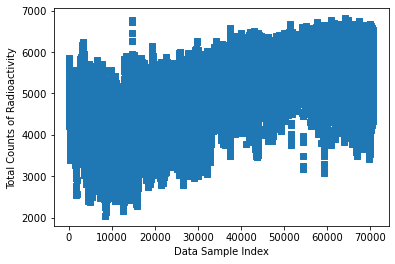

In [10]:
rad_count_column = rad_DataFrame.loc[:, "total_count"]
# radioactivity count numpy array
rad_count = rad_count_column.values

# plots counts of radioactivty detected in counts/second
plt.scatter(x=range(len(rad_count)), y=rad_count, marker=",")
plt.xlabel("Data Sample Index") # x-axis label
plt.ylabel("Total Counts of Radioactivity") # y-axis label
plt.show()


Cell creates a scatter plot to visualize the apparent percentages of Potassium 40 recorded during each reading

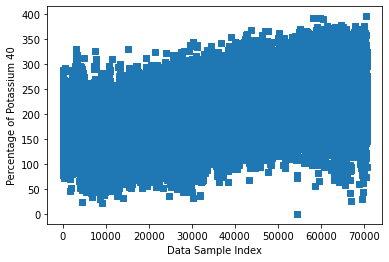

In [11]:
K_count_column = rad_DataFrame.loc[:, "app_K"]
# percentages of potassium numpy array
K_count = K_count_column.values

# plots apparent percentages of Potassium 40 at each reading
plt.scatter(x=range(len(K_count)), y=K_count, marker=",")
plt.xlabel("Data Sample Index") # x-axis label
plt.ylabel("Percentage of Potassium 40") # y-axis label
plt.show()

Percentages exceed 100 for some reason?

Cell creates a scatter plot to visualize the apparent amount of Uranium (measured in parts/million) seen during each reading. The readings actually record the radioactive isotope Bismuth 214 instead of Uranium directly, because this isotope is used to estimate the concentrations of Uranium. 

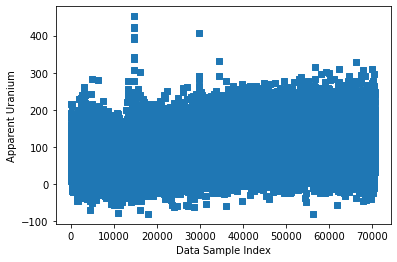

In [12]:
U_count_column = rad_DataFrame.loc[:, "app_U"]
# Bismuth 214 count numpy array
U_count = U_count_column.values

# plots apparent concentrations of Uranium as Bismuth 214
plt.scatter(x=range(len(U_count)), y=U_count, marker=",")
plt.xlabel("Data Sample Index") # x-axis label
plt.ylabel("Apparent Uranium") # y-axis label
plt.show()

Cell creates a scatter plot to visualize the apparent amount of Thorium (measured in parts/million) seen during each reading. In this data, the element Thorium is measured by estimating its concentation using the isotope Thallium 208.

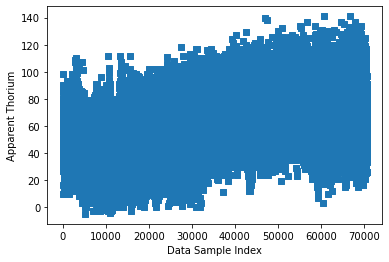

In [13]:
Th_count_column = rad_DataFrame.loc[:, "app_Th"]
# Thallium 208 count numpy array
Th_count = Th_count_column.values

# plots apparent concentrations of Thorium as Thallium 208
plt.scatter(x=range(len(Th_count)), y=Th_count, marker=",")
plt.xlabel("Data Sample Index") # x-axis label
plt.ylabel("Apparent Thorium") # y-axis label
plt.show()

## Clustering

New DataFrame holds the feature data that will be used for clustering

Adapted code from "https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019"

In [14]:
# Organizes data with chosen features for clustering
resmag_data_column = mag_DataFrame.loc[:, ["resmag"]]
rad_count_column = rad_DataFrame.loc[range(len(resmag_data_column)), "total_count"]

clustering_DataFrame = pd.concat([resmag_data_column, rad_count_column], axis=1)


In [15]:
clustering_DataFrame.head(10)

,resmag,total_count
0,-246.2,4943.0
1,-246.2,4943.0
2,-246.2,4943.0
3,-247.4,5080.0
4,-250.1,5151.0
5,-249.4,5112.0
6,-248.8,5280.0
7,-247.2,5283.0
8,-246.6,5151.0
9,-247.2,5013.0


In [16]:
# Function used to normalize input data to values between 0 and 1
def normalize(input_data):
    scaler = MinMaxScaler()
    scaler.fit(input_data)
    return scaler.transform(input_data)

In [17]:
# turns DataFrame into an array of raw numerical values
# full dataset takes too long to cluster so only used first 40,000 index values
agglomerative_data_array = clustering_DataFrame.head(40000).values

# normalizes data
agglomerative_data_array = normalize(agglomerative_data_array)
print(agglomerative_data_array)

[[0.73543879 0.61453698]
 [0.73543879 0.61453698]
 [0.73543879 0.61453698]
 ...
 [0.09284516 0.80334817]
 [0.09508105 0.7880907 ]
 [0.0941867  0.82983683]]


In [18]:
# # initializes model and fits model with radiometric and magnetic data

# # chose 3 clusters, as there are 3 different elements detected in the dataset (Potassium, Uranium, and Thorium)
# clustering_model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
# clustering_model.fit(agglomerative_data_array)

In [19]:
# # array stores labels of the data that were assigned by the clustering algorithm
# cluster_labels = clustering_model.labels_

# # visualization of cluster using scatter plot
# plt.scatter(agglomerative_data_array[cluster_labels==0, 0], agglomerative_data_array[cluster_labels==0, 1], marker='o', color='red')
# plt.scatter(agglomerative_data_array[cluster_labels==1, 0], agglomerative_data_array[cluster_labels==1, 1], marker='o', color='blue')
# plt.scatter(agglomerative_data_array[cluster_labels==2, 0], agglomerative_data_array[cluster_labels==2, 1], marker='o', color='green')
# plt.xlabel("Residual Magnetic Value")
# plt.ylabel("Total Counts of Radioactivity")
# plt.title("Agglomerative")
# plt.show()

#### K Means Clustering
Adapted code from: https://github.com/codebasics/py/blob/master/ML/13_kmeans/13_kmeans_tutorial.ipynb

In [20]:
df = pd.DataFrame(clustering_DataFrame, columns = ['resmag', 'total_count']) #redefine the dataframe

def elbow_graph():
    sse = [] #elbow graph to find the ideal k value
    k_rng = range(1,10)
    for k in k_rng:
        km = KMeans(n_clusters=k)
        km.fit(df[['resmag','total_count']])
        sse.append(km.inertia_)
    plt.xlabel('K')
    plt.ylabel('Sum of squared error')
    plt.plot(k_rng, sse)
    plt.show()


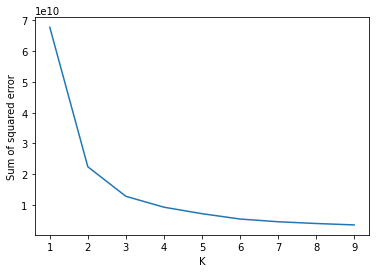

In [21]:
# Displays Graph
elbow_graph()

Data Normalization

In [22]:
def scale(): # scale the data from zero to one
    scaler = MinMaxScaler()
    scaler.fit(df[['total_count']])
    df['total_count'] = scaler.transform(df[['total_count']])

    scaler.fit(df[['resmag']])
    df['resmag'] = scaler.transform(df[['resmag']])

KMeans Algorithm and Visualization of Results

In [23]:
def kmeans():
    km = KMeans(n_clusters=3) #three clusters via elbow graph
    pred_y = km.fit_predict(df) #assigns a cluster to each row of the dataset
    print((pred_y))
    df['cluster'] = pred_y  #appends the cluster predictions to the dataset
    # print(df)

    #visualize the clusters
    km1 = df[pred_y==0]
    km2 = df[pred_y==1]
    km3 = df[pred_y==2]
    plt.scatter(km1.resmag,km1['total_count'], color='red')
    plt.scatter(km2.resmag,km2['total_count'], color='blue')
    plt.scatter(km3.resmag,km3['total_count'], color='green')
    plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='white',marker='*',label='centroid') #mark centroids
    plt.xlabel("Residual Magnetic Value")
    plt.ylabel("Total Counts of Radioactivity")
    plt.title("KMeans")
    plt.show()

[1 1 1 ... 1 1 1]


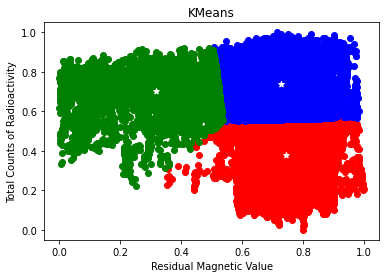

In [24]:
scale()
kmeans()

##### DBSCAN

Used to experiment with how DBSCAN performs at clustering ours radiometric and magnetic data

Following code cells are used to determine the optimal value of epsilon, which is an essential parameter for the DBSCAN model

code adapted from: "https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc"

In [25]:
# Input data for DBSCAN clustering
dbscan_data_array = clustering_DataFrame.values

# Normalized input data
dbscan_data_array = normalize(dbscan_data_array)

Code to calculate/collect distance calculations

In [26]:
# Used to calculate distance from each point to its nearest neighbor
neighbors = NearestNeighbors(n_neighbors=2).fit(dbscan_data_array)

# Returns arrays containing individual distances and indices of points analyzed 
kn_distances, indices = neighbors.kneighbors(dbscan_data_array)

# Sorts distance calculations
kn_distances = np.sort(kn_distances, axis=0)

Graph of distance calculations. The value of epsilon is "found at the point of maximum curvature".

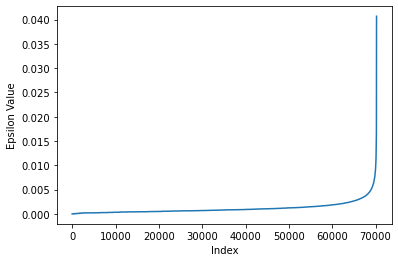

In [27]:
# Graphs distance calculation results
plt.plot(kn_distances[:,1])
plt.xlabel("Index")
plt.ylabel("Epsilon Value")

plt.show()

DBSCAN using the optimal epsilon value of 0.005 and a min_sample value of 5

In [28]:
# optimal espilon value
optimal_eps = 0.005

# DBSCAN model and fitting
dbscan = DBSCAN(eps=optimal_eps, min_samples=5)
dbscan.fit(dbscan_data_array)

# list of clusters and points
dbscan_clusters = dbscan.labels_

Graph of results and clusters

Text(0, 0.5, 'Total Counts of Radioactivity')

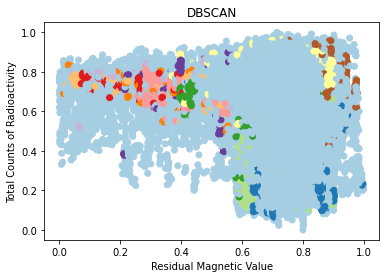

In [29]:
# Graph Results
y_pred = dbscan.fit_predict(dbscan_data_array)

plt.scatter(dbscan_data_array[:,0], dbscan_data_array[:,1],c=y_pred, cmap='Paired')
plt.title("DBSCAN")
plt.xlabel("Residual Magnetic Value")
plt.ylabel("Total Counts of Radioactivity")

#### Spatially Constrained Clustering

Converting Pandas DataFrames to to GeoPandas DataFrames with longitude/latitude (x, y) coordinates in geometry column

In [30]:
# Sub-DataFrames to extract features from main DataFrames
df_long = rad_DataFrame.loc[:, ["longitude"]]
df_lat = rad_DataFrame.loc[:, ["latitude"]]

# Creates GeoSeries to store coordinate points
coord_points = gp.GeoSeries.from_xy(x=df_long, y=df_lat)

# GeoPandas GeoDataFrame of radioactivity count / resmag data
spatial_geo_df = gp.GeoDataFrame(clustering_DataFrame.copy(), crs="EPSG:4326", geometry=coord_points)
spatial_geo_df

,resmag,total_count,geometry
0,-246.2,4943.0,POINT (-103.47720 33.96630)
1,-246.2,4943.0,POINT (-103.47720 33.96630)
2,-246.2,4943.0,POINT (-103.47720 33.96630)
3,-247.4,5080.0,POINT (-103.47770 33.96680)
4,-250.1,5151.0,POINT (-103.47790 33.96740)
...,...,...,...
70223,181.4,5548.0,POINT (-103.33490 34.98330)
70224,179.9,5497.0,POINT (-103.33420 34.98330)
70225,179.9,4936.0,POINT (-103.31940 34.98330)
70226,179.9,5007.0,POINT (-103.31870 34.98330)


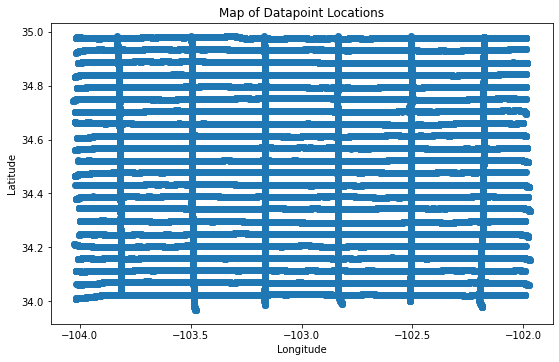

In [31]:
# Spatial map of data locations
spatial_geo_df.plot(figsize=(9, 9))
plt.title("Map of Datapoint Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/FRI_PROJECT/lib/python3.9/site-packages/libpysal/weights/util.py:1073: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in first_choice])


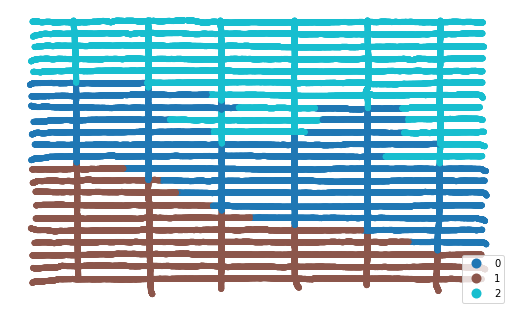

In [32]:
# Spatially constrained agglomerative clustering
spatial_weights = KNN.from_dataframe(spatial_geo_df, k=4)
model = AgglomerativeClustering(linkage='ward', connectivity=spatial_weights.sparse, n_clusters=3)
# Fit algorithm to the data
spatial_agglomerative_data = normalize(clustering_DataFrame[["resmag", "total_count"]].values)
model.fit(spatial_agglomerative_data)


# Graping Model
spatial_geo_df['labels'] = model.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
spatial_geo_df.plot(column='labels', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

Spatially Constrained Clustering but with splitting the dataset into smaller segments. In addition, we added the Apparent Uranium feature (along with residual magnetic value and total counts of radioactivity) to the clustering dataset and chose to have 2 clusters outputted. This will allow us to have clusters that represent areas of possibly high uranium concentration and areas of low uranium concentration.

In [33]:
# Function That Turns Full Data Set Into Smaller Rectangular Shaped Segments
# This will allow us to cluster individual segments of the dataset, instead of the entire dataset at once
longitude_latidude = mag_DataFrame[["longitude", "latitude"]].copy()
uranium_reading = rad_DataFrame.loc[range(len(mag_DataFrame)), 'app_U'].copy()

split_DataFrame = pd.concat([clustering_DataFrame, longitude_latidude, uranium_reading], axis=1)
split_DataFrame = split_DataFrame[['resmag', 'total_count', 'longitude', 'latitude', 'app_U']].copy()

split_DataFrame

def create_data_segment(startLat, startLong, latIncrement, longIncrement):
    segment_dataFrame = pd.DataFrame()
    # Determine Increment is Valid Index
    long_max = split_DataFrame['longitude'].max()
    lat_max = split_DataFrame['latitude'].max()
    
    lat_range = startLat + latIncrement
    if lat_range >= lat_max:
        lat_range = lat_max
        
    long_range = startLong + longIncrement
    if long_range >= long_max:
        long_range = long_max
    
    long_conditional = pd.Series(split_DataFrame['longitude']).between(startLong, long_range)
    lat_conditional = pd.Series(split_DataFrame['latitude']).between(startLat, lat_range)
    
    for i in range(len(lat_conditional)):
        if long_conditional[i] == True and lat_conditional[i] == True:
            segment_dataFrame = segment_dataFrame.append(split_DataFrame.iloc[i])

    return segment_dataFrame
    
test = create_data_segment(split_DataFrame['latitude'][0], split_DataFrame['longitude'][0], 0.2, 1.0)

test

,resmag,total_count,longitude,latitude,app_U
0,-246.2,4943.0,-103.4772,33.9663,82.0
1,-246.2,4943.0,-103.4772,33.9663,82.0
2,-246.2,4943.0,-103.4772,33.9663,82.0
56,0.0,5241.0,-103.1665,33.9854,63.0
60,-2.7,4979.0,-103.1665,33.9860,106.0
...,...,...,...,...,...
13052,-485.8,4788.0,-102.8360,34.1656,97.0
13053,-249.6,4507.0,-102.5072,34.1656,127.0
13057,-270.5,3603.0,-103.1651,34.1659,105.0
13058,-485.8,4614.0,-102.8360,34.1661,50.0


In [34]:
# Function Adds Cluster Labels to split_DataFrame to aid in Plotting Later
def add_model_labels(segmented_DataFrame):
    labels_column = segmented_DataFrame["labels"]
    for i in range(len(segmented_DataFrame)):
        row = segmented_DataFrame.iloc[i]
        label_num = row["labels"]
        longitude = row["longitude"]
        latitude = row["latitude"]
        
        # Add Labels to Correct Row in split_DataFrame
        index = split_DataFrame[(split_DataFrame["latitude"]==latitude) & (split_DataFrame["longitude"] == longitude)].index
        split_DataFrame.loc[index, "labels"] = label_num

In [35]:
# Function To Perform the Spatially Constrained Clustering
split_DataFrame["labels"] = ""

def spatially_constrained_clustering(segmented_DataFrame):
    # temp columns to construct GeoDataFrame
    temp_long = segmented_DataFrame['longitude']
    temp_lat = segmented_DataFrame['latitude']

    # Coordinates to construct GeoDataFrame
    coordinates = gp.GeoSeries.from_xy(x=temp_long, y=temp_lat)

    # Temporary GeoDataFrame comprised of a rectangular segment of data that will be clustered
    temp_geo = gp.GeoDataFrame(segmented_DataFrame.copy(), crs="EPSG:4326", geometry=coordinates)

    # Spatially constrained agglomerative clustering
    spatial_weights = KNN.from_dataframe(temp_geo, k=5)
    model = AgglomerativeClustering(linkage='ward', connectivity=spatial_weights.sparse, n_clusters=2)
    
    # Fit algorithm with specified data segment
    segmented_agglomerative_data = normalize(temp_geo[["resmag", "total_count", "app_U"]].values) # Normalizes data
    model.fit(segmented_agglomerative_data)

    # Model Cluster Labels
    segmented_DataFrame["labels"] = model.labels_
    # Adds model labels to split_DataFrame
    add_model_labels(segmented_DataFrame)
    
    return segmented_DataFrame

segment = spatially_constrained_clustering(create_data_segment(split_DataFrame['latitude'][0], split_DataFrame['longitude'][0], 0.2, 1.0))
split_DataFrame

/opt/homebrew/Caskroom/miniforge/base/envs/FRI_PROJECT/lib/python3.9/site-packages/libpysal/weights/util.py:1073: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in first_choice])


,resmag,total_count,longitude,latitude,app_U,labels
0,-246.2,4943.0,-103.4772,33.9663,82.0,1.0
1,-246.2,4943.0,-103.4772,33.9663,82.0,1.0
2,-246.2,4943.0,-103.4772,33.9663,82.0,1.0
3,-247.4,5080.0,-103.4777,33.9668,97.0,
4,-250.1,5151.0,-103.4779,33.9674,32.0,
...,...,...,...,...,...,...
70223,181.4,5548.0,-103.1605,35.0483,98.0,
70224,179.9,5497.0,-103.1600,35.0488,111.0,
70225,179.9,4936.0,-103.1592,35.0493,127.0,
70226,179.9,5007.0,-103.1592,35.0493,87.0,


In [36]:
# Function Handles the Main Control Flow For Doing Spatially Constrained Clustering in segments of the dataset
def segmented_clustering(latitude_increment, longitude_increment):
    start_lat = split_DataFrame['latitude'][0]
    
    long_max = split_DataFrame['longitude'].max()
    lat_max = split_DataFrame['latitude'].max()
    
    while start_lat < lat_max:
        start_long = split_DataFrame['longitude'][0]
        while start_long < long_max:
            data_segment = create_data_segment(start_lat, start_long, latitude_increment, longitude_increment)
            spatially_constrained_clustering(data_segment)
            
            start_long = start_long + longitude_increment
        start_lat = start_lat + latitude_increment
        
# segmented_clustering(0.5, 1)

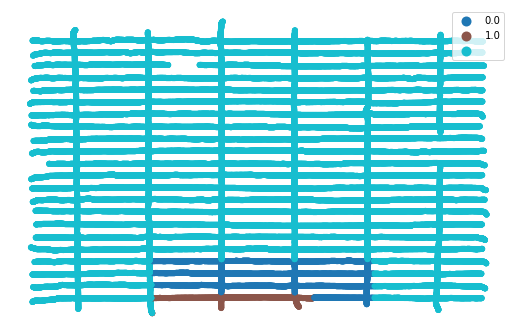

In [37]:
# Turn Segmented DataFrame into a GeoDataFrame
segment_long = split_DataFrame.loc[:, ["longitude"]]
segment_lat = split_DataFrame.loc[:, ["latitude"]]

# Creates GeoSeries to store coordinate points
coords = gp.GeoSeries.from_xy(x=segment_long, y=segment_lat)

# GeoPandas GeoDataFrame of radioactivity count / resmag data
segmented_geo_df = gp.GeoDataFrame(split_DataFrame.copy(), crs="EPSG:4326", geometry=coords)

f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
segmented_geo_df.plot(column='labels', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

In [38]:
# Interactive Map of Plot Locations
spatial_map = folium.Map(location=[34.6, -103], zoom_start=9)

def add_point(lat, long, color):
    folium.Circle(
    radius=1,
    location=[lat, long],
    color=color,
    fill=True,
    ).add_to(spatial_map)
    
for i in range(len(segmented_geo_df)):
    latitude_point = df_lat.to_numpy()[i]
    longitude_point = df_long.to_numpy()[i]
    cluster_label = segmented_geo_df['labels'].to_numpy()[i]
    color = ''
    if cluster_label == 0:
        color = 'blue'
        # add cluster/data point on to interactive map
        add_point(latitude_point, longitude_point, color)
    elif cluster_label == 1:
        color = 'red'
        # add cluster/data point on to interactive map
        add_point(latitude_point, longitude_point, color)
    

# spatial_map

## Feature Selection

What are the possible predictors?
1. Resmag
2. Air Temperature
3. Air Pressure

What are the response features?
1. Total Radioactivity
2. Apparent Uranium
3. Apparent Thorium
4. Atmospheric Bismuth
5. Apparent Potassium-40

### Boxplots of Possible Predictors

/opt/homebrew/Caskroom/miniforge/base/envs/FRI_PROJECT/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/FRI_PROJECT/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/FRI_PROJECT/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


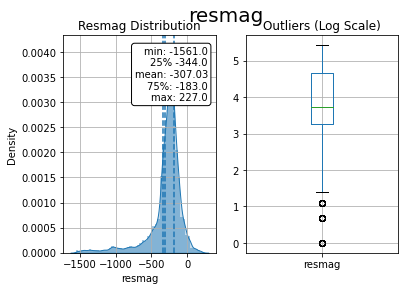

/opt/homebrew/Caskroom/miniforge/base/envs/FRI_PROJECT/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


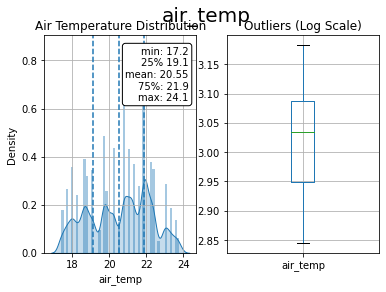

/opt/homebrew/Caskroom/miniforge/base/envs/FRI_PROJECT/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


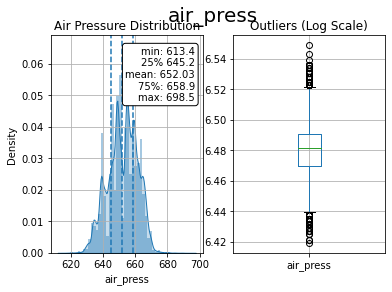

In [39]:
# resmag
# set up the plots
x = "resmag"
fig, ax = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = False)
fig.suptitle(x, fontsize = 20)

# get the distribution
ax[0].title.set_text('Resmag Distribution')
var = rad_DataFrame[x].fillna(rad_DataFrame[x].mean())
breaks = np.quantile(var, q = np.linspace(0, 1, 11))
var = var[(var > breaks[0]) & (var < breaks[10])]
sea.distplot(var, hist = True, kde = True, kde_kws = {"shade": True}, ax = ax[0])
des = rad_DataFrame[x].describe()
ax[0].axvline(des["25%"], ls = '--')
ax[0].axvline(des["mean"], ls = '--')
ax[0].axvline(des["75%"], ls = '--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x : str(x))
box = '\n'.join(("min: " + des["min"], "25% " + des["25%"], "mean: " + des["mean"], "75%: " + des["75%"], "max: " +
                 des["max"]))
ax[0].text(0.95, 0.95, box, transform = ax[0].transAxes, fontsize = 10, va = 'top', ha = "right", bbox = dict(boxstyle
            = 'round', facecolor = 'white', alpha = 1))

# boxplot
ax[1].title.set_text("Outliers (Log Scale)")
temp_df = pd.DataFrame(rad_DataFrame[x])
temp_df[x] = np.log(temp_df[x])
temp_df.boxplot(column = x, ax = ax[1])
plt.show()

# air temperature
# set up the plots
x = "air_temp"
fig, ax = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = False)
fig.suptitle(x, fontsize = 20)

# get the distribution
ax[0].title.set_text('Air Temperature Distribution')
var = rad_DataFrame[x].fillna(rad_DataFrame[x].mean())
breaks = np.quantile(var, q = np.linspace(0, 1, 11))
var = var[(var > breaks[0]) & (var < breaks[10])]
sea.distplot(var, hist = True, kde = True, kde_kws = {"shade": True}, ax = ax[0])
des = rad_DataFrame[x].describe()
ax[0].axvline(des["25%"], ls = '--')
ax[0].axvline(des["mean"], ls = '--')
ax[0].axvline(des["75%"], ls = '--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x : str(x))
box = '\n'.join(("min: " + des["min"], "25% " + des["25%"], "mean: " + des["mean"], "75%: " + des["75%"], "max: " +
                 des["max"]))
ax[0].text(0.95, 0.95, box, transform = ax[0].transAxes, fontsize = 10, va = 'top', ha = "right", bbox = dict(boxstyle
            = 'round', facecolor = 'white', alpha = 1))

# boxplot
ax[1].title.set_text("Outliers (Log Scale)")
temp_df = pd.DataFrame(rad_DataFrame[x])
temp_df[x] = np.log(temp_df[x])
temp_df.boxplot(column = x, ax = ax[1])
plt.show()

# air pressure
# set up the plots
x = "air_press"
fig, ax = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = False)
fig.suptitle(x, fontsize = 20)

# get the distribution
ax[0].title.set_text('Air Pressure Distribution')
rad_DataFrame[x].replace({-999.9 : rad_DataFrame[x].mean()}, inplace = True)
var = rad_DataFrame[x]
breaks = np.quantile(var, q = np.linspace(0, 1, 11))
var = var[(var > breaks[0]) & (var < breaks[10])]
sea.distplot(var, hist = True, kde = True, kde_kws = {"shade": True}, ax = ax[0])
des = rad_DataFrame[x].describe()
ax[0].axvline(des["25%"], ls = '--')
ax[0].axvline(des["mean"], ls = '--')
ax[0].axvline(des["75%"], ls = '--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x : str(x))
box = '\n'.join(("min: " + des["min"], "25% " + des["25%"], "mean: " + des["mean"], "75%: " + des["75%"], "max: " +
                 des["max"]))
ax[0].text(0.95, 0.95, box, transform = ax[0].transAxes, fontsize = 10, va = 'top', ha = "right", bbox = dict(boxstyle
            = 'round', facecolor = 'white', alpha = 1))

# boxplot
ax[1].title.set_text("Outliers (Log Scale)")
temp_df = pd.DataFrame(rad_DataFrame[x])
temp_df[x] = np.log(temp_df[x])
temp_df.boxplot(column = x, ax = ax[1])
plt.show()


All predictor and response features are quantitative.
Thus, we'll be using linear regression tests to see if a potential input feature has predictive power for radioactivity
levels:

/opt/homebrew/Caskroom/miniforge/base/envs/FRI_PROJECT/lib/python3.9/site-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


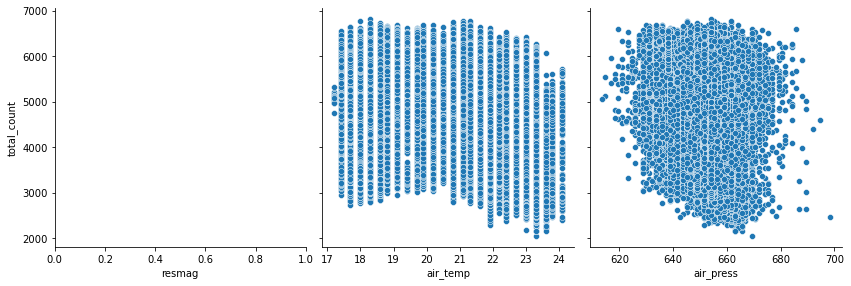

                            OLS Regression Results                            
Dep. Variable:            total_count   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1566.
Date:                Thu, 25 Nov 2021   Prob (F-statistic):               0.00
Time:                        13:05:38   Log-Likelihood:            -5.8389e+05
No. Observations:               70651   AIC:                         1.168e+06
Df Residuals:                   70649   BIC:                         1.168e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4789.5803      5.638    849.537      0.0

In [40]:
#RESPONSE FEATURE: total_counts
#first, visualize the correlations with total_count
sea.pairplot(rad_DataFrame, x_vars = ['resmag', 'air_temp', 'air_press'], y_vars = 'total_count', size = 4, aspect = 1
             , kind = 'scatter')
plt.show()
# resmag
# add an intercept to the regression line sm generates by default
x = "resmag"
y = "total_count"
potential_predictor = sm.add_constant(rad_DataFrame[x])
# fit the regression line using OLS
lr = sm.OLS(rad_DataFrame[y], potential_predictor).fit()
# check the results to see if it is predictive
print(lr.summary())

# air_temp
# add an intercept to the regression line sm generates by default
x = "air_temp"
y = "total_count"
potential_predictor = sm.add_constant(rad_DataFrame[x])
# fit the regression line using OLS
lr = sm.OLS(rad_DataFrame[y], potential_predictor).fit()
# check the results to see if it is predictive
print(lr.summary())

# air_press
# add an intercept to the regression line sm generates by default
x = "air_press"
y = "total_count"
potential_predictor = sm.add_constant(rad_DataFrame[x])
# fit the regression line using OLS
lr = sm.OLS(rad_DataFrame[y], potential_predictor).fit()
# check the results to see if it is predictive
# print(lr.summary())

Results: all 3 possible predictors have predictive power with total_count. The relationships are not very strong, so
perhaps it is nonlinear

/opt/homebrew/Caskroom/miniforge/base/envs/FRI_PROJECT/lib/python3.9/site-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


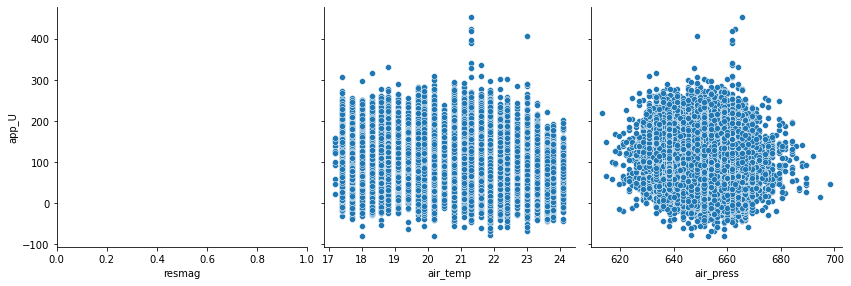

                            OLS Regression Results                            
Dep. Variable:                  app_U   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     419.0
Date:                Thu, 25 Nov 2021   Prob (F-statistic):           7.48e-93
Time:                        13:05:38   Log-Likelihood:            -3.7556e+05
No. Observations:               70651   AIC:                         7.511e+05
Df Residuals:                   70649   BIC:                         7.511e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         96.3917      0.295    326.257      0.0

In [41]:
#RESPONSE FEATURE: app_U
#first, visualize the correlations with total_count
sea.pairplot(rad_DataFrame, x_vars = ['resmag', 'air_temp', 'air_press'], y_vars = 'app_U', size = 4, aspect = 1
             , kind = 'scatter')
plt.show()
# resmag
# add an intercept to the regression line sm generates by default
x = "resmag"
y = "app_U"
potential_predictor = sm.add_constant(rad_DataFrame[x])
# fit the regression line using OLS
lr = sm.OLS(rad_DataFrame[y], potential_predictor).fit()
# check the results to see if it is predictive
print(lr.summary())

# air_temp
# add an intercept to the regression line sm generates by default
x = "air_temp"
y = "app_U"
potential_predictor = sm.add_constant(rad_DataFrame[x])
# fit the regression line using OLS
lr = sm.OLS(rad_DataFrame[y], potential_predictor).fit()
# check the results to see if it is predictive
print(lr.summary())

# air_press
# add an intercept to the regression line sm generates by default
x = "air_press"
y = "app_U"
potential_predictor = sm.add_constant(rad_DataFrame[x])
# fit the regression line using OLS
lr = sm.OLS(rad_DataFrame[y], potential_predictor).fit()
# check the results to see if it is predictive
print(lr.summary())

Results: all 3 possible predictors have predictive power with app_U. The relationships are not very strong, so
perhaps it is nonlinear

/opt/homebrew/Caskroom/miniforge/base/envs/FRI_PROJECT/lib/python3.9/site-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


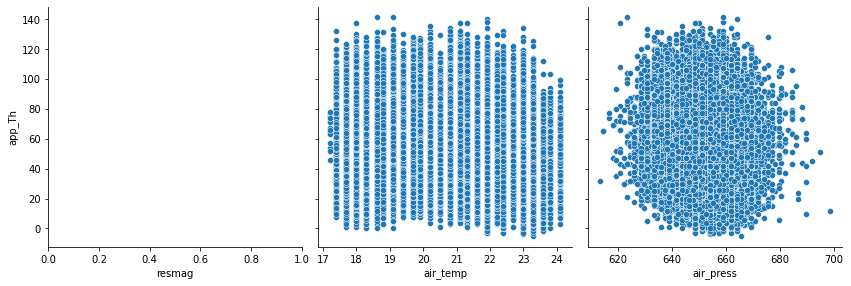

                            OLS Regression Results                            
Dep. Variable:                 app_Th   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1580.
Date:                Thu, 25 Nov 2021   Prob (F-statistic):               0.00
Time:                        13:05:38   Log-Likelihood:            -3.2351e+05
No. Observations:               70651   AIC:                         6.470e+05
Df Residuals:                   70649   BIC:                         6.470e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         56.7864      0.141    401.537      0.0

In [42]:
#RESPONSE FEATURE: app_Th
#first, visualize the correlations with total_count
sea.pairplot(rad_DataFrame, x_vars = ['resmag', 'air_temp', 'air_press'], y_vars = 'app_Th', size = 4, aspect = 1
             , kind = 'scatter')
plt.show()
# resmag
# add an intercept to the regression line sm generates by default
x = "resmag"
y = "app_Th"
potential_predictor = sm.add_constant(rad_DataFrame[x])
# fit the regression line using OLS
lr = sm.OLS(rad_DataFrame[y], potential_predictor).fit()
# check the results to see if it is predictive
print(lr.summary())

# air_temp
# add an intercept to the regression line sm generates by default
x = "air_temp"
y = "app_Th"
potential_predictor = sm.add_constant(rad_DataFrame[x])
# fit the regression line using OLS
lr = sm.OLS(rad_DataFrame[y], potential_predictor).fit()
# check the results to see if it is predictive
print(lr.summary())

# air_press
# add an intercept to the regression line sm generates by default
x = "air_press"
y = "app_Th"
potential_predictor = sm.add_constant(rad_DataFrame[x])
# fit the regression line using OLS
lr = sm.OLS(rad_DataFrame[y], potential_predictor).fit()
# check the results to see if it is predictive
print(lr.summary())

Results: all 3 possible predictors have predictive power with app_Th. The relationships are not very strong, so
perhaps it is nonlinear

/opt/homebrew/Caskroom/miniforge/base/envs/FRI_PROJECT/lib/python3.9/site-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


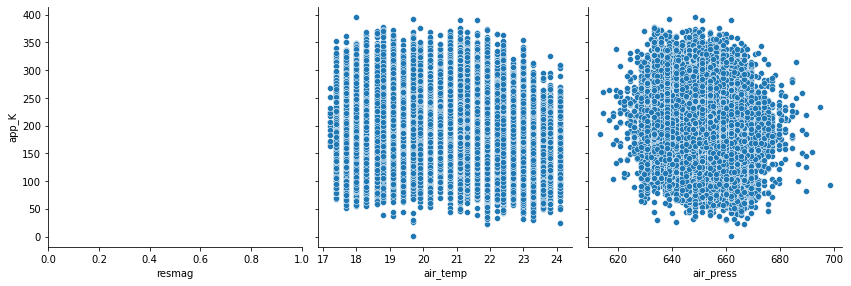

                            OLS Regression Results                            
Dep. Variable:                  app_K   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     793.4
Date:                Thu, 25 Nov 2021   Prob (F-statistic):          1.36e-173
Time:                        13:05:39   Log-Likelihood:            -3.8355e+05
No. Observations:               70651   AIC:                         7.671e+05
Df Residuals:                   70649   BIC:                         7.671e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        192.6442      0.331    582.303      0.0

In [43]:
#RESPONSE FEATURE: app_K
#first, visualize the correlations with total_count
sea.pairplot(rad_DataFrame, x_vars = ['resmag', 'air_temp', 'air_press'], y_vars = 'app_K', size = 4, aspect = 1
             , kind = 'scatter')
plt.show()
# resmag
# add an intercept to the regression line sm generates by default
x = "resmag"
y = "app_K"
potential_predictor = sm.add_constant(rad_DataFrame[x])
# fit the regression line using OLS
lr = sm.OLS(rad_DataFrame[y], potential_predictor).fit()
# check the results to see if it is predictive
print(lr.summary())

# air_temp
# add an intercept to the regression line sm generates by default
x = "air_temp"
y = "app_K"
potential_predictor = sm.add_constant(rad_DataFrame[x])
# fit the regression line using OLS
lr = sm.OLS(rad_DataFrame[y], potential_predictor).fit()
# check the results to see if it is predictive
print(lr.summary())

# air_press
# add an intercept to the regression line sm generates by default
x = "air_press"
y = "app_K"
potential_predictor = sm.add_constant(rad_DataFrame[x])
# fit the regression line using OLS
lr = sm.OLS(rad_DataFrame[y], potential_predictor).fit()
# check the results to see if it is predictive
print(lr.summary())

Results: all 3 possible predictors have predictive power with app_K. The relationships are not very strong, so
perhaps it is nonlinear

/opt/homebrew/Caskroom/miniforge/base/envs/FRI_PROJECT/lib/python3.9/site-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


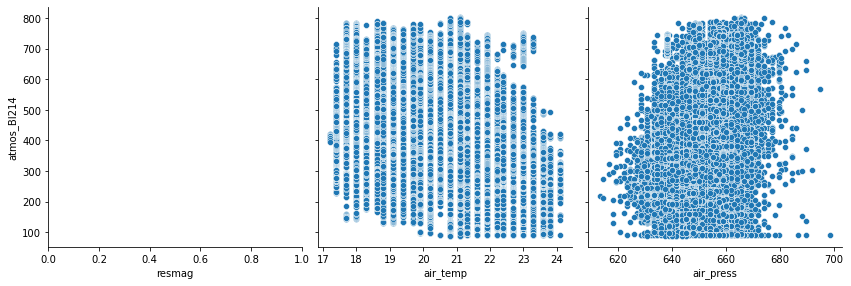

                            OLS Regression Results                            
Dep. Variable:            atmos_BI214   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1209.
Date:                Thu, 25 Nov 2021   Prob (F-statistic):          9.89e-263
Time:                        13:05:39   Log-Likelihood:            -4.5803e+05
No. Observations:               70651   AIC:                         9.161e+05
Df Residuals:                   70649   BIC:                         9.161e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        385.7478      0.949    406.329      0.0

In [44]:
#RESPONSE FEATURE: atmos_BI214
#first, visualize the correlations with total_count
sea.pairplot(rad_DataFrame, x_vars = ['resmag', 'air_temp', 'air_press'], y_vars = 'atmos_BI214', size = 4, aspect = 1
             , kind = 'scatter')
plt.show()
# resmag
# add an intercept to the regression line sm generates by default
x = "resmag"
y = "atmos_BI214"
potential_predictor = sm.add_constant(rad_DataFrame[x])
# fit the regression line using OLS
lr = sm.OLS(rad_DataFrame[y], potential_predictor).fit()
# check the results to see if it is predictive
print(lr.summary())

# air_temp
# add an intercept to the regression line sm generates by default
x = "air_temp"
y = "atmos_BI214"
potential_predictor = sm.add_constant(rad_DataFrame[x])
# fit the regression line using OLS
lr = sm.OLS(rad_DataFrame[y], potential_predictor).fit()
# check the results to see if it is predictive
print(lr.summary())

# air_press
# add an intercept to the regression line sm generates by default
x = "air_press"
y = "atmos_BI214"
potential_predictor = sm.add_constant(rad_DataFrame[x])
# fit the regression line using OLS
lr = sm.OLS(rad_DataFrame[y], potential_predictor).fit()
# check the results to see if it is predictive
print(lr.summary())

Results: all 3 possible predictors have predictive power with app_U. The relationships are not very strong, so
perhaps it is nonlinear

### Conclusion
While the p and F values for our 3 possible predictor variables air_temp, air_press, and resmag were all very low, which
is indicative of radioactivity (both total and of various radioactive elements), the R-squared values are also low. It's
possible that we got significant results due to the large sample size (> 70000 rows), but we cannot yet discount these
as features. The one thing we can be confident about is that we need to take the analysis further with these three
features and see where it takes us.

## Neural Network

##### Adapted Code From (https://towardsdatascience.com/regression-based-neural-networks-with-tensorflow-v2-0-predicting-average-daily-rates-e20fffa7ac9a)

Organizing DataFrame of Predictor and Response Features

In [45]:
# Temp Imports, move to top later
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

In [46]:
predictor_df = clustering_DataFrame.copy()
response_df = pd.DataFrame(rad_DataFrame.loc[range(len(predictor_df)), 'app_U'])

Organize Predictor and Response Features in Numpy Arrays

In [47]:
# Predictor Feature Array
predictor_array = predictor_df.to_numpy()
# Adds Bias Column to Array
predictor_array = sm.add_constant(predictor_array, prepend=True)

# Response Feature Array
response_array = response_df.to_numpy()

Splits the Dataset Into Training and Testing Data (utilizes 80, 20 split)

In [48]:
TRAIN_SIZE = 0.80
TEST_SIZE = 0.20

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(predictor_array, response_array, 
                                                                        train_size=TRAIN_SIZE, test_size=TEST_SIZE, random_state=7)

Performs Normalization on the Various Datasets That Will be Used in the Model

In [49]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Normalization of Predictor Training Data
scaler_x.fit(X_train)
x_train_normalized = scaler_x.transform(X_train)

# Normalization of Predictor Testing Data
scaler_x.fit(X_test)
x_test_normalized = scaler_x.transform(X_test)

# Normalization of Response Training Data
scaler_y.fit(y_train)
y_train_normalized = scaler_y.transform(y_train)

# Normalization of Response Test Data
scaler_y.fit(y_test)
y_test_normalized = scaler_y.transform(y_test)

Neural Network Hyperparameters (3 Layers Total, 1 Hidden Layer)

In [50]:
# Nodes In Input Layer is 2 Features + 1
num_input_nodes = 3

# Nodes in Output Layer is 1 for 1 response feature
num_output_nodes = 1

# Nodes In Hidden Layer is Double of the Nodes in the Input Layer
min_hidden_nodes = int((2/3 * num_input_nodes) + num_output_nodes)
max_hidden_nodes = int(56182 / (2 * (3 + 1)))

### Neural Network Hyperparameter Tuning Function (adapted code from https://keras.io/guides/keras_tuner/getting_started/)

Function to Define Neural Network Depth and Hyperparameter Tune

In [51]:
# Build of Model Function to do Hyperparameter Tuning with Keras Tuner
def build_model(hp):
    model = keras.Sequential(name="uranium_predictions")
    # Input Layer
    model.add(layers.Dense(num_input_nodes, input_dim=num_input_nodes, activation="relu", kernel_initializer="normal", name="input_layer"))
    # Hidden Layer with Hyperparameter Tuning
    model.add(
        layers.Dense(
            # Tune number of units.
            units=hp.Int("units", min_value=num_input_nodes, max_value=80, step=2),
            activation="relu",
            name="hidden_layer"
        )
    )
    # Output Layer
    model.add(layers.Dense(num_output_nodes, activation="linear", name="output_layer"))
    
    # Compile Model With Optimizer and Loss Specifications
    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
        metrics=["mean_squared_error"],
    )
    return model

# Overall Model Architecture Outline **SAVE***
# model = keras.Sequential(name="uranium_predictions")
# model.add(layers.Dense(num_input_nodes, input_dim=num_input_nodes, activation="relu", kernel_initializer="normal", name="input_layer"))
# model.add(layers.Dense(num_hidden_layer_nodes, activation="relu", name="hidden_layer"))
# model.add(layers.Dense(num_output_nodes, activation="linear", name="output_layer"))
# model.summary()

Instantiating Hyperband Tuner for Neural Network

In [54]:
# Hyberband Tuning Function
tuner = kt.Hyperband(
    hypermodel=build_model,
    objective="mean_squared_error",
    max_epochs=100,
    factor=3
)

# Callback Function for Early Stopping Regularization To Prevent Overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)

Initiates Hyperparameter Search Using Hyberband

In [55]:
tuner.search(x_train_normalized, y_train_normalized, epochs=100, 
             validation_data=(x_test_normalized, y_test_normalized), callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
    The hyperparameter search is complete. The optimal number of units in the hidden
    layer is {best_hps.get('units')} """)

Trial 38 Complete [00h 00m 01s]
mean_squared_error: 0.006165224127471447

Best mean_squared_error So Far: 0.006121885497123003
Total elapsed time: 00h 01m 01s
INFO:tensorflow:Oracle triggered exit

    The hyperparameter search is complete. The optimal number of units in the hidden
    layer is 7 
